In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from scipy.stats import bootstrap, mannwhitneyu, ttest_ind, wilcoxon
from statsmodels.tsa.stattools import acf
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# cfg.params.low_pass = 0.1
# cfg.params.high_pass = 4

# cfg.params.low_pass = 80
# cfg.params.high_pass = 30

cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15

# cfg.params.stride = 120
# # cfg.params.window = 5
# cfg.params.window = 30

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [-36.120676111111116, -26.045618333333337]


In [7]:
for data_class, agent in agent_data:
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        for dose in ['high', 'low']:
            if dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
                print(f"{agent} | {monkey} | {dose} | {len(agent_data[(data_class, agent)]['session_lists'][monkey][dose])}")

propofol | Mary | high | 10
propofol | MrJones | high | 11
ketamine | SPOCK | high | 8
ketamine | SPOCK | low | 0
ketamine | PEDRI | high | 8
ketamine | PEDRI | low | 0
dexmedetomidine | SPOCK | high | 8
dexmedetomidine | SPOCK | low | 0
dexmedetomidine | PEDRI | high | 8
dexmedetomidine | PEDRI | low | 0


In [8]:
top_percent = 0.1
dose = 'high'
area = 'all'

In [9]:
def get_num_crs(delase_results, session, top_percent=0.1, area='all'):
    return delase_results[session][area].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))])).sum()
def get_num_crs_pos(delase_results, session, top_percent=0.1, area='all'):
    return delase_results[session][area].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))][x[:int(top_percent*len(x))] >= 0])).sum()

In [10]:
for (data_class, agent), data_dict in agent_data.items():
    print("--------------------------------")
    print(f"{agent}:")
    print("--------------------------------")
    unique_areas = np.unique(np.concatenate([list(d.keys()) for d in data_dict['delase_results'].values()]))
    delase_results = data_dict['delase_results']
    num_crs = {}
    num_crs_pos = {}
    for area in unique_areas:
        print(f"Area: {area}")
        print("---------")
        num_crs[area] = {}
        num_crs_pos[area] = {}
        for session in delase_results.keys():
            if area in delase_results[session].keys():
                num_crs[area][session] = get_num_crs(delase_results, session, top_percent, area)
                num_crs_pos[area][session] = get_num_crs_pos(delase_results, session, top_percent, area)
    
        total_crs = np.sum(list(num_crs[area].values()))
        total_crs_pos = np.sum(list(num_crs_pos[area].values()))
        total_crs_neg = total_crs - total_crs_pos
        print(f"Total CRs: {total_crs}")
        print(f"Positive CRs: {total_crs_pos} ({total_crs_pos/total_crs*100:.2f}%)")
        print(f"Negative CRs: {total_crs_neg} ({total_crs_neg/total_crs*100:.2f}%)")

--------------------------------
propofol:
--------------------------------
Area: all
---------
Total CRs: 1748991
Positive CRs: 27535 (1.57%)
Negative CRs: 1721456 (98.43%)
--------------------------------
ketamine:
--------------------------------
Area: all
---------
Total CRs: 1700419
Positive CRs: 1225 (0.07%)
Negative CRs: 1699194 (99.93%)
--------------------------------
dexmedetomidine:
--------------------------------
Area: all
---------
Total CRs: 1952298
Positive CRs: 9937 (0.51%)
Negative CRs: 1942361 (99.49%)


### Noise Filter Info

In [26]:
for data_class, agent in agent_data:
    print("--------------------------------")
    print(f"{agent}:")
    print("--------------------------------")
    min_bad_electrodes = np.inf
    max_bad_electrodes = 0
    min_bad_windows_percent = np.inf
    max_bad_windows_percent = 0
    for session in agent_data[(data_class, agent)]['noise_filter_info']:
        noise_filter_info = agent_data[(data_class, agent)]['noise_filter_info'][session]
        # print(f"# Bad Electrodes: {len(noise_filter_info['bad_electrodes'])}")
        if len(noise_filter_info['bad_electrodes']) < min_bad_electrodes:
            min_bad_electrodes = len(noise_filter_info['bad_electrodes'])
        if len(noise_filter_info['bad_electrodes']) > max_bad_electrodes:
            max_bad_electrodes = len(noise_filter_info['bad_electrodes'])
        total_windows = len(noise_filter_info['window_df'])
        bad_windows_percent = (1 - (len(noise_filter_info['valid_window_starts'])/total_windows))*100
        if bad_windows_percent < min_bad_windows_percent:
            min_bad_windows_percent = bad_windows_percent
        if bad_windows_percent > max_bad_windows_percent:
            max_bad_windows_percent = bad_windows_percent
    print(f"# Bad Electrodes: {min_bad_electrodes} - {max_bad_electrodes}")
    print(f"% Bad Windows: {min_bad_windows_percent:.2f}% - {max_bad_windows_percent:.2f}%")

--------------------------------
propofol:
--------------------------------
# Bad Electrodes: 4 - 23
% Bad Windows: 5.90% - 44.17%
--------------------------------
ketamine:
--------------------------------
# Bad Electrodes: 14 - 30
% Bad Windows: 3.89% - 57.13%
--------------------------------
dexmedetomidine:
--------------------------------
# Bad Electrodes: 11 - 28
% Bad Windows: 0.97% - 51.88%


# Aggregate Plots

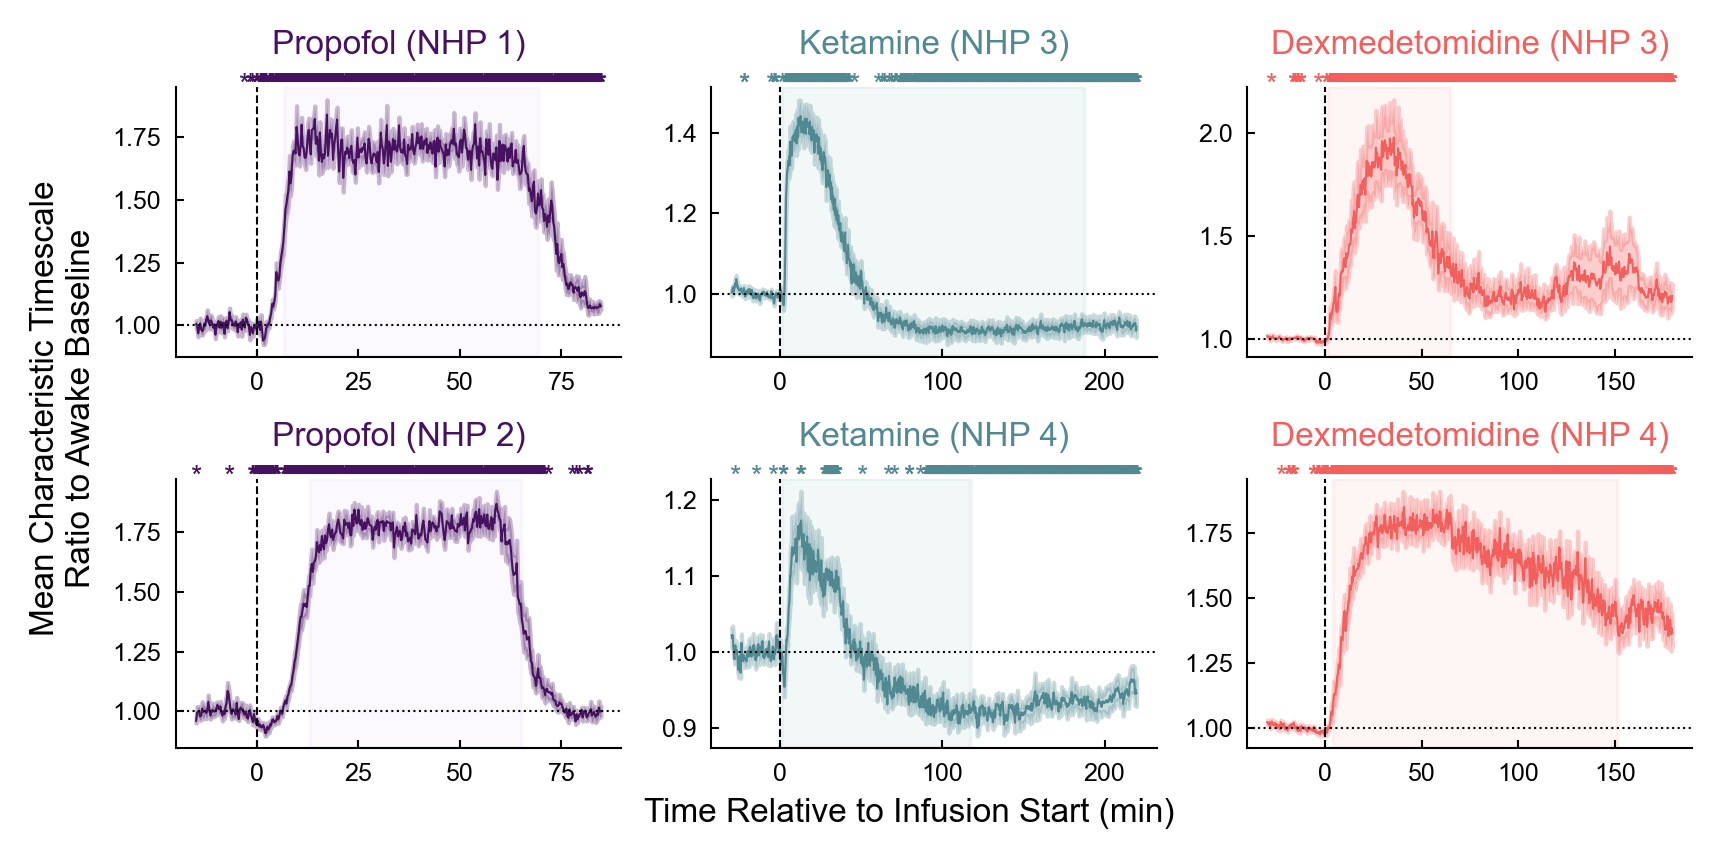

In [40]:
# Grid version of plot_session_stability_grouped
plot_range_by_agent = {
    'propofol': (-15, 85),
    'ketamine': (-30, 220),
    'dexmedetomidine': (-30, 180)
}

area = 'all'

if dose == 'high':
    grid_save_path = os.path.join(img_save_dir, f"stability_grouped_grid_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
else:
    grid_save_path = os.path.join(img_save_dir, f"stability_grouped_grid_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")

grid_plot_data = plot_session_stability_grouped_grid(
    cfg=cfg,
    agent_data=agent_data,            # dict keyed by (data_class, agent)
    data_class=None,                  # or a single class for all
    data_class_by_agent=None,         # or dict agent -> data_class
    top_percent=top_percent,
    timescales=True,
    curve_colors=curve_colors,
    loc_roc_colors=loc_roc_colors,
    dose=dose,
    save_path=grid_save_path,
    verbose=True,
    area=area,
    area_by_agent=None,               # or dict agent -> area
    plot_range_by_agent=plot_range_by_agent,
    return_data=True,
    data_type='delase',
    star_height_base=0.95,
    layout='nhp_rows',
    figsize=(6, 3),
    # layout='agent_rows',
    # figsize=(5, 6),
)


propofol high unconscious-awake: 0.0009765625
propofol high unconscious-awake: 0.00048828125
ketamine high unconscious-awake: 0.00390625
ketamine high recovery-awake: 0.01171875
ketamine high unconscious-awake: 0.0390625
ketamine high recovery-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625


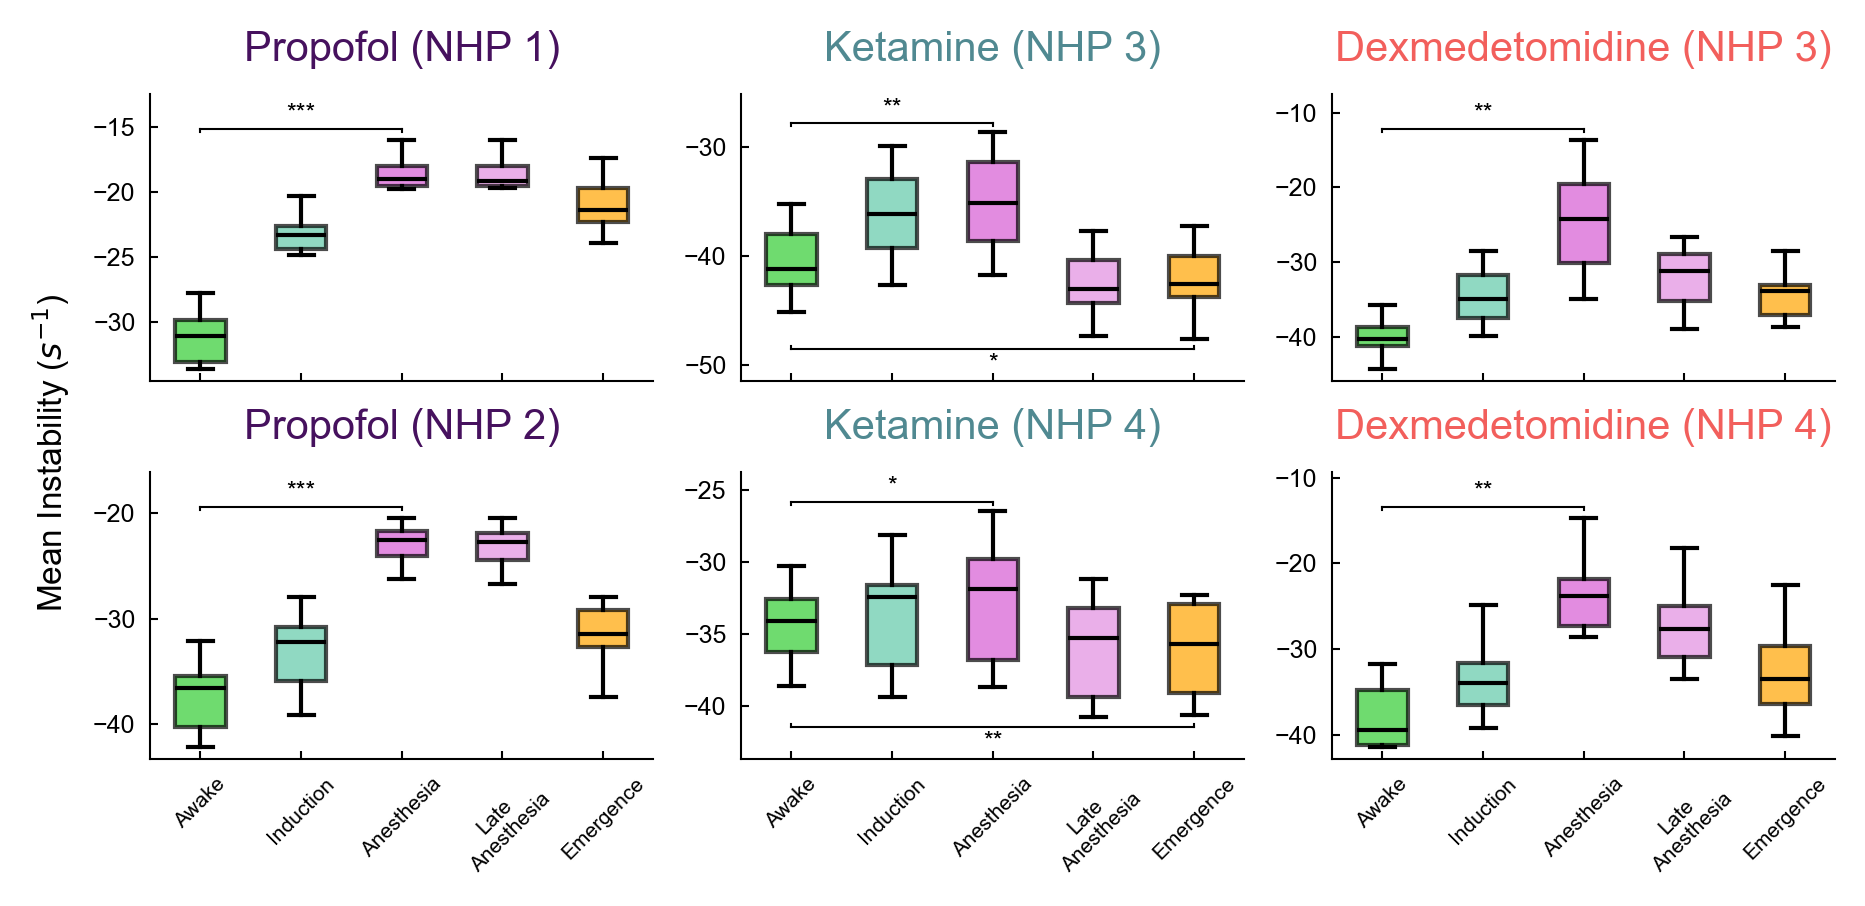

In [41]:
top_percent = 0.1
area = 'all'

# Prepare results_by_agent dict for grid function
results_by_agent = {}
for (data_class, agent), data_dict in agent_data.items():
    results_by_agent[(data_class, agent)] = data_dict['delase_results']

# Create single grid save path
if dose == 'high':
    grid_save_path = os.path.join(img_save_dir, f"section_stability_boxes_grid_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
else:
    grid_save_path = os.path.join(img_save_dir, f"section_stability_boxes_grid_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")

# Use grid function to plot all agents on a single grid
grid_section_means = plot_section_stability_boxes_grid(
    cfg=cfg,
    agent_data=agent_data,
    results_by_agent=results_by_agent,
    top_percent=top_percent,
    curve_colors=curve_colors,
    # figsize=(5, 6),
    # layout='agent_rows',
    figsize=(6, 3),
    layout='nhp_rows',
    dose=dose,
    save_path=grid_save_path,
    section_info_type='plot',
    verbose=False,
    area=area,
    sharex=True
)

# Convert grid return format to match original format: section_means[(data_class, agent)]
section_means = {}
for (data_class, agent) in agent_data.keys():
    if agent in grid_section_means:
        section_means[(data_class, agent)] = grid_section_means[agent]

propofol high unconscious-awake: 0.0009765625
propofol high unconscious-awake: 0.00048828125
ketamine high unconscious-awake: 0.00390625
ketamine high recovery-awake: 0.01171875
ketamine high unconscious-awake: 0.0390625
ketamine high recovery-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625


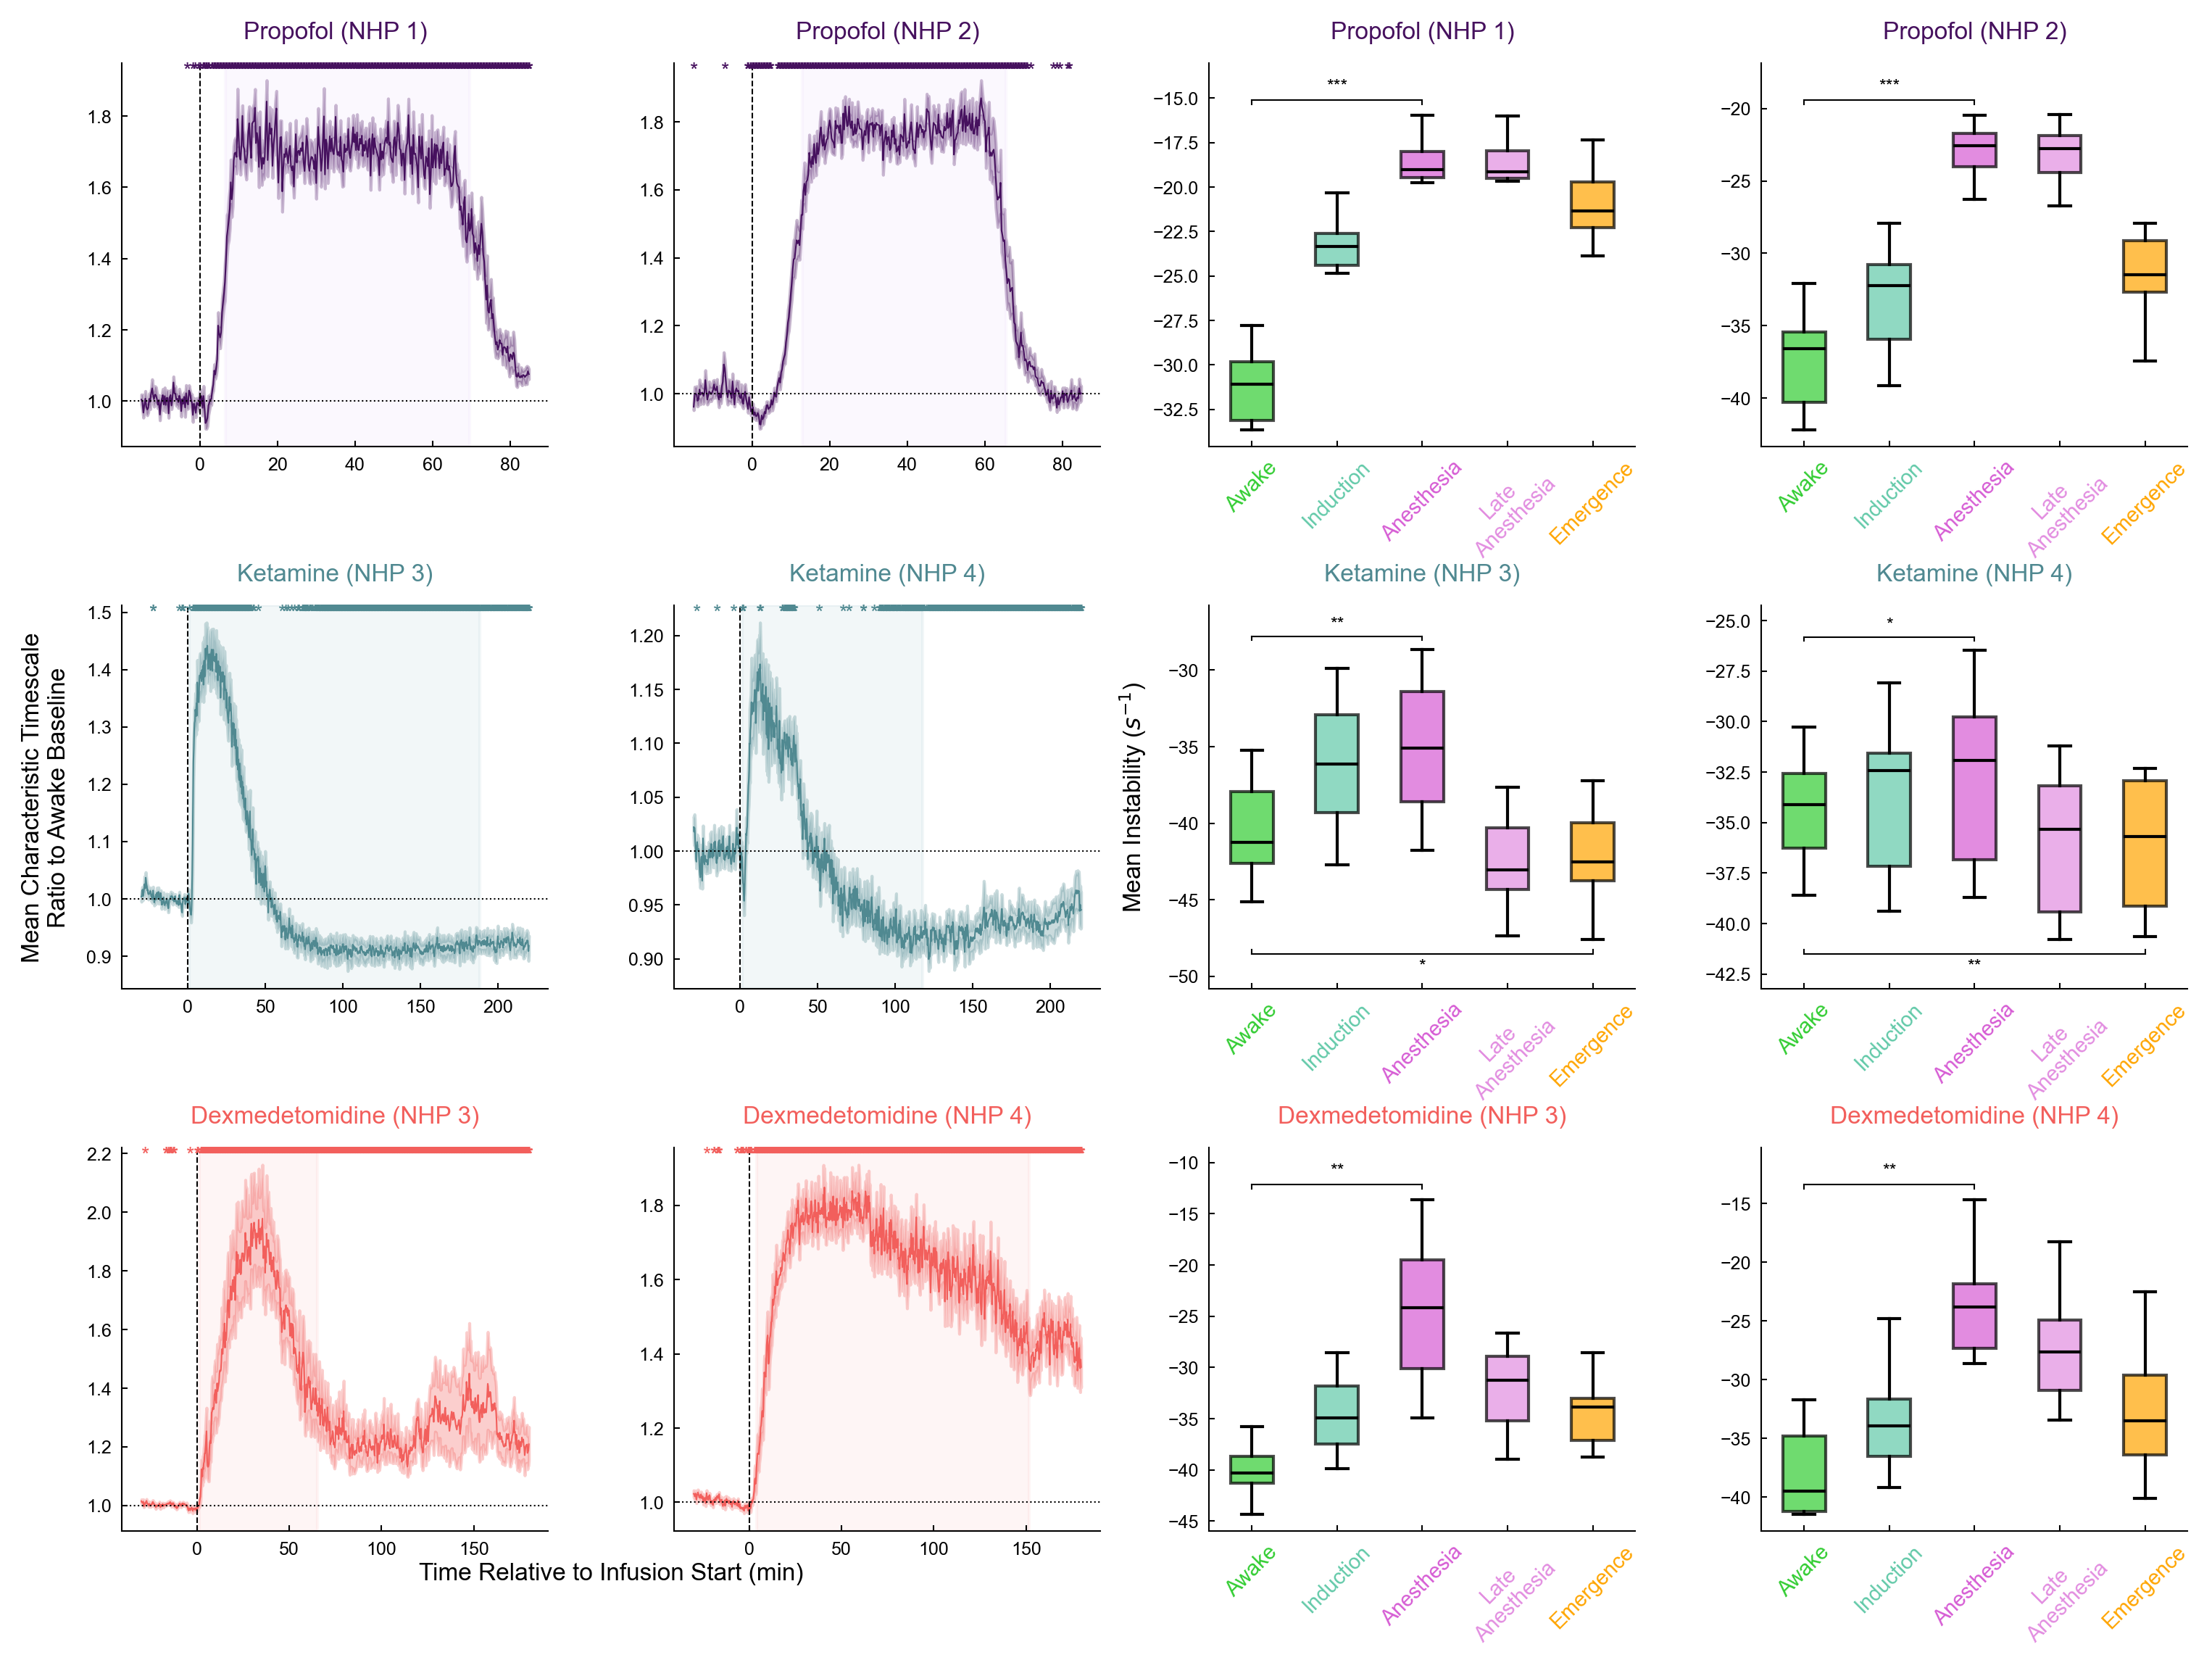

In [42]:
# Combined plot: Grouped stability + Section stability in a 3x4 grid
top_percent = 0.1
area = 'all'

# Prepare results_by_agent dict for combined function
results_by_agent = {}
for (data_class, agent), data_dict in agent_data.items():
    results_by_agent[(data_class, agent)] = data_dict['delase_results']

# Plot range by agent
plot_range_by_agent = {
    'propofol': (-15, 85),
    'ketamine': (-30, 220),
    'dexmedetomidine': (-30, 180)
}

# Create combined grid save path
if dose == 'high':
    combined_save_path = os.path.join(img_save_dir, f"combined_stability_grid_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
else:
    combined_save_path = os.path.join(img_save_dir, f"combined_stability_grid_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")

# Use combined function to plot both grouped and section stability on a single 3x4 grid
combined_plot_data = plot_combined_stability_grid(
    cfg=cfg,
    agent_data=agent_data,
    results_by_agent=results_by_agent,
    top_percent=top_percent,
    timescales=True,
    curve_colors=curve_colors,
    loc_roc_colors=loc_roc_colors,
    # figsize=(12, 9),
    figsize=(10, 7.5),
    dose=dose,
    save_path=combined_save_path,
    section_info_type='plot',
    verbose=False,
    area=area,
    plot_range_by_agent=plot_range_by_agent,
    return_data=True,
    data_type='delase',
    star_height_base=0.95
)


# Statistics

### Mean Instability Values Across Animals and Sections

In [11]:
mean_values = {}
infusion_starts = {}
top_percents = np.arange(0.01, 0.305, 0.01)
# top_percents = np.arange(0.02, 1.01, 0.02)
top_percents[np.argmin(np.abs(top_percents - 0.1))] = 0.1
for data_class, agent in anesthetic_agent_list:
    mean_values[(data_class, agent)] = {}
    infusion_starts[(data_class, agent)] = {}
    cfg.params.data_class = data_class
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        sessions_to_use = agent_data[(data_class, agent)]['session_lists'][monkey]['high']
        mean_values[(data_class, agent)][monkey] = {}
        infusion_starts[(data_class, agent)][monkey] = {}
        for session in tqdm(sessions_to_use, desc=f'{agent} | {monkey}'):
            df = agent_data[(data_class, agent)]['delase_results'][session]['all']
            section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')
            mean_values[(data_class, agent)][monkey][session] = {}
            infusion_starts[(data_class, agent)][monkey][session] = infusion_start
            for top_percent in top_percents:
                mean_values[(data_class, agent)][monkey][session][top_percent] = {}
                for section in ['Awake', 'Anesthesia', 'Emergence']:
                    times_tup = section_info[np.where([tup[0] == section for tup in section_info])[0][0]][1]
                    df_window_starts_rel_minutes = (df.window_start - infusion_start)/60
                    mean_values[(data_class, agent)][monkey][session][top_percent][section] = df[(df_window_starts_rel_minutes >= times_tup[0]) & (df_window_starts_rel_minutes <= times_tup[1])].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).mean()

propofol | Mary:   0%|          | 0/10 [00:00<?, ?it/s]

propofol | MrJones:   0%|          | 0/11 [00:00<?, ?it/s]

ketamine | SPOCK:   0%|          | 0/8 [00:00<?, ?it/s]

ketamine | PEDRI:   0%|          | 0/8 [00:00<?, ?it/s]

dexmedetomidine | SPOCK:   0%|          | 0/8 [00:00<?, ?it/s]

dexmedetomidine | PEDRI:   0%|          | 0/8 [00:00<?, ?it/s]

In [13]:
from IPython.display import display, Markdown
np.random.seed(42)
all_section_means = {}
power_analysis_results = {}
run_power_analysis = False
for data_class, agent in anesthetic_agent_list:
    all_section_means[(data_class, agent)] = {}
    power_analysis_results[(data_class, agent)] = {}
    for monkey in mean_values[(data_class, agent)]:
        print("="*50)
        print(f"{agent} | {monkey}")
        print("="*50)
        all_section_means[(data_class, agent)][monkey] = {}
        power_analysis_results[(data_class, agent)][monkey] = {}
        for top_percent in top_percents:

            all_section_means[(data_class, agent)][monkey][top_percent] = {}
            for section in ['Awake', 'Anesthesia', 'Emergence']:
                section_means = [mean_values[(data_class, agent)][monkey][session][top_percent][section] for session in mean_values[(data_class, agent)][monkey]]
                # print(f"{agent} | {monkey} | {section} | {np.mean(section_means)} (+/- {np.std(section_means)/np.sqrt(len(section_means))})")
                all_section_means[(data_class, agent)][monkey][top_percent][section] = section_means


            if top_percent == 0.1:
                print(f"-"*10)
                print(f"Top {top_percent*100:.0f}% of Instability")
                print(f"-"*10)
                awake_means = np.array(all_section_means[(data_class, agent)][monkey][top_percent]['Awake'])
                anesthesia_means = np.array(all_section_means[(data_class, agent)][monkey][top_percent]['Anesthesia'])
                emergence_means = np.array(all_section_means[(data_class, agent)][monkey][top_percent]['Emergence'])

                median_diff_anesthesia_awake, wilcoxon_p_value_anesthesia_awake, ci_anesthesia_awake = compute_wilcoxon_and_median_diff(awake_means, anesthesia_means, alternative='less')
                if agent == 'ketamine':
                    alternative = 'greater'
                    print(anesthesia_means - awake_means)                
                else:
                    alternative = 'less'
                median_diff_emergence_awake, wilcoxon_p_value_emergence_awake, ci_emergence_awake = compute_wilcoxon_and_median_diff(awake_means, emergence_means, alternative=alternative)
                
                print(f"Anesthesia v Awake")
                
                display(Markdown(f"""<span style='font-size:12pt'>
                    p={wilcoxon_p_value_anesthesia_awake:.3e}, median difference Anesthesia - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: {median_diff_anesthesia_awake:.3f}, 95% CI: [{ci_anesthesia_awake[0]:.3f}, {ci_anesthesia_awake[1]:.3f}]
                </span>"""))
                print(f"Emergence v Awake")
                display(Markdown(f"""<span style='font-size:12pt'>
                    p={wilcoxon_p_value_emergence_awake:.3e}, median difference Emergence - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: {median_diff_emergence_awake:.3f}, 95% CI: [{ci_emergence_awake[0]:.3f}, {ci_emergence_awake[1]:.3f}]
                </span>"""))
                print("\n")

                if run_power_analysis:
                    print(f"Power Analysis")
                    if agent == 'ketamine':
                        alternative = 'greater'
                    else:
                        alternative = 'less'
                    power_analysis_results[(data_class, agent)][monkey]['anesthesia_awake'] = power_analysis(awake_means, anesthesia_means, alternative='less', n_simulations=1000)
                    power_analysis_results[(data_class, agent)][monkey]['emergence_awake'] = power_analysis(awake_means, emergence_means, alternative=alternative, n_simulations=1000)
                    print(f"Anesthesia v Awake: {power_analysis_results[(data_class, agent)][monkey]['anesthesia_awake']:.3f}")
                    print(f"Emergence v Awake: {power_analysis_results[(data_class, agent)][monkey]['emergence_awake']:.3f}")
                    print("\n")


propofol | Mary
----------
Top 10% of Instability
----------
Anesthesia v Awake


<span style='font-size:12pt'>
                    p=9.766e-04, median difference Anesthesia - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 12.970, 95% CI: [11.657, 13.649]
                </span>

Emergence v Awake


<span style='font-size:12pt'>
                    p=9.766e-04, median difference Emergence - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 10.291, 95% CI: [8.799, 11.606]
                </span>



propofol | MrJones
----------
Top 10% of Instability
----------
Anesthesia v Awake


<span style='font-size:12pt'>
                    p=4.883e-04, median difference Anesthesia - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 14.285, 95% CI: [13.557, 16.512]
                </span>

Emergence v Awake


<span style='font-size:12pt'>
                    p=4.883e-04, median difference Emergence - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 6.144, 95% CI: [4.124, 7.859]
                </span>



ketamine | SPOCK
----------
Top 10% of Instability
----------
[6.66399   5.8562965 6.0928993 2.7236328 6.9121685 5.4072666 3.3653069
 6.412197 ]
Anesthesia v Awake


<span style='font-size:12pt'>
                    p=3.906e-03, median difference Anesthesia - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 5.975, 95% CI: [3.365, 6.664]
                </span>

Emergence v Awake


<span style='font-size:12pt'>
                    p=1.172e-02, median difference Emergence - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: -2.095, 95% CI: [-3.114, -0.844]
                </span>



ketamine | PEDRI
----------
Top 10% of Instability
----------
[ 2.3259048  -0.6223793   2.0756798   2.9678917   2.758339    3.816372
 -0.6879196   0.14026642]
Anesthesia v Awake


<span style='font-size:12pt'>
                    p=3.906e-02, median difference Anesthesia - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 2.201, 95% CI: [-0.283, 2.968]
                </span>

Emergence v Awake


<span style='font-size:12pt'>
                    p=3.906e-03, median difference Emergence - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: -1.582, 95% CI: [-2.634, -0.354]
                </span>



dexmedetomidine | SPOCK
----------
Top 10% of Instability
----------
Anesthesia v Awake


<span style='font-size:12pt'>
                    p=3.906e-03, median difference Anesthesia - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 16.420, 95% CI: [6.571, 22.117]
                </span>

Emergence v Awake


<span style='font-size:12pt'>
                    p=3.906e-03, median difference Emergence - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 5.340, 95% CI: [2.191, 7.652]
                </span>



dexmedetomidine | PEDRI
----------
Top 10% of Instability
----------
Anesthesia v Awake


<span style='font-size:12pt'>
                    p=3.906e-03, median difference Anesthesia - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 14.491, 95% CI: [12.851, 16.317]
                </span>

Emergence v Awake


<span style='font-size:12pt'>
                    p=3.906e-03, median difference Emergence - Awake Instability in <span style='font-size:12pt;'>s</span><sup style="font-size:10pt;">-1</sup>: 4.824, 95% CI: [2.199, 8.081]
                </span>

In [14]:
# Generate and save power analysis table
import pandas as pd
import os

# Map monkey names to NHP labels
monkey_to_nhp = {
    'Mary': 'NHP 1',
    'MrJones': 'NHP 2',
    'SPOCK': 'NHP 3',
    'PEDRI': 'NHP 4'
}

# Create the power analysis table
table_data = []
for data_class, agent in anesthetic_agent_list:
    for monkey in power_analysis_results[(data_class, agent)]:
        nhp = monkey_to_nhp.get(monkey, monkey)
        
        # For all agents, show Anesthesia v Awake
        power_anesthesia = power_analysis_results[(data_class, agent)][monkey]['anesthesia_awake']
        table_data.append({
            'Agent': agent.capitalize(),
            'NHP': nhp,
            'Comparison': 'Anesthesia v Awake',
            'Power': f'{power_anesthesia:.3f}'
        })
        
        # For ketamine only, also show Emergence v Awake
        if agent == 'ketamine':
            power_emergence = power_analysis_results[(data_class, agent)][monkey]['emergence_awake']
            table_data.append({
                'Agent': agent.capitalize(),
                'NHP': nhp,
                'Comparison': 'Emergence v Awake',
                'Power': f'{power_emergence:.3f}'
            })

# Create DataFrame
df_power = pd.DataFrame(table_data)

# Sort by Agent, then NHP, then Comparison
agent_order = ['Propofol', 'Ketamine', 'Dexmedetomidine']
nhp_order = ['NHP 1', 'NHP 2', 'NHP 3', 'NHP 4']
df_power['Agent'] = pd.Categorical(df_power['Agent'], categories=agent_order, ordered=True)
df_power['NHP'] = pd.Categorical(df_power['NHP'], categories=nhp_order, ordered=True)
df_power = df_power.sort_values(['Agent', 'NHP', 'Comparison']).reset_index(drop=True)

# Create HTML table
html_table = df_power.to_html(index=False, classes='table', table_id='power_analysis')

# Ensure the supp directory exists
supp_dir = os.path.join(img_save_dir, 'supp')
os.makedirs(supp_dir, exist_ok=True)

# Save HTML table
html_path = os.path.join(supp_dir, 'power_analysis_table.html')
with open(html_path, 'w') as f:
    f.write(html_table)

print(f"Power analysis table saved to: {html_path}")
print("\n")
print(df_power.to_string(index=False))


Power analysis table saved to: /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/figure_images/supp/power_analysis_table.html


          Agent   NHP         Comparison Power
       Propofol NHP 1 Anesthesia v Awake 1.000
       Propofol NHP 2 Anesthesia v Awake 1.000
       Ketamine NHP 3 Anesthesia v Awake 1.000
       Ketamine NHP 3  Emergence v Awake 0.899
       Ketamine NHP 4 Anesthesia v Awake 0.630
       Ketamine NHP 4  Emergence v Awake 1.000
Dexmedetomidine NHP 3 Anesthesia v Awake 1.000
Dexmedetomidine NHP 4 Anesthesia v Awake 1.000


In [13]:
# COMBINED MODELS
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2

statistical_info = {}

top_percent = 0.1

for data_class, agent in anesthetic_agent_list:
    statistical_info[(data_class, agent)] = {}
    for monkey in all_section_means[(data_class, agent)]:
        statistical_info[(data_class, agent)][monkey] = {}
        
        awake_means = all_section_means[(data_class, agent)][monkey][top_percent]['Awake']
        anesthesia_means = all_section_means[(data_class, agent)][monkey][top_percent]['Anesthesia']
        emergence_means = all_section_means[(data_class, agent)][monkey][top_percent]['Emergence']

        # Create the data
        data = {
            'session': np.concatenate(([f"S{i+1}" for i in np.arange(len(awake_means))], [f"S{i+1}" for i in np.arange(len(anesthesia_means))], [f"S{i+1}" for i in np.arange(len(emergence_means))])),
            'session_order': np.concatenate((np.arange(len(awake_means)), np.arange(len(anesthesia_means)), np.arange(len(emergence_means)))),
            'state':  ['Awake']*len(awake_means) + ['Anesthesia']*len(anesthesia_means) + ['Emergence']*len(emergence_means),
            'instability': np.concatenate((awake_means, anesthesia_means, emergence_means))
        }
        df = pd.DataFrame(data)
        statistical_info[(data_class, agent)][monkey]['df'] = df
    
        # --- Define Formulas ---
        # Explicitly setting 'Awake' as the reference for all models
        BASE_STATE_FORMULA = "instability ~ C(state, Treatment(reference='Awake'))"
        # Formula 1: Simple OLS
        FORMULA_OLS = BASE_STATE_FORMULA
        # Formula 2: LMEM (Clustering Control)
        FORMULA_LMEM = BASE_STATE_FORMULA
        # Formula 3: Sequential LMEM (Clustering + Carry-over Control)
        FORMULA_SEQUENTIAL = f"{BASE_STATE_FORMULA} + session_order"
        
        model_simple_ml = smf.ols(FORMULA_OLS, data=df).fit(reml=False)
        model_lmem_ml = smf.mixedlm(FORMULA_LMEM, data=df, groups=df["session"]).fit(reml=False)

        statistical_info[(data_class, agent)][monkey]['model_simple_ml'] = model_simple_ml
        statistical_info[(data_class, agent)][monkey]['model_lmem_ml'] = model_lmem_ml

        LRT_stat_clust = 2 * (model_lmem_ml.llf - model_simple_ml.llf)
        p_value_clust = chi2.sf(LRT_stat_clust, 1)

        statistical_info[(data_class, agent)][monkey]['LRT_stat_clust'] = LRT_stat_clust
        statistical_info[(data_class, agent)][monkey]['p_value_clust'] = p_value_clust

        model_sequential_ml = smf.mixedlm(
            FORMULA_SEQUENTIAL, 
            data=df, 
            groups=df["session"]
        ).fit(reml=False)

        LRT_stat_seq = 2 * (model_sequential_ml.llf - model_lmem_ml.llf)
        p_value_seq = chi2.sf(LRT_stat_seq, 1) 

        statistical_info[(data_class, agent)][monkey]['LRT_stat_seq'] = LRT_stat_seq
        statistical_info[(data_class, agent)][monkey]['p_value_seq'] = p_value_seq
        
        Final_Formula = FORMULA_LMEM
        if p_value_seq < 0.05:
            Final_Formula = FORMULA_SEQUENTIAL


        model_final_reml = smf.mixedlm(
            Final_Formula, 
            data=df, 
            groups=df["session"],
        ).fit(reml=True)

        # Calculate Intraclass Correlation Coefficient (ICC)
        variance_residual = model_final_reml.scale
        variance_session = model_final_reml.cov_re.iloc[0, 0] # Random intercept variance
        icc = variance_session / (variance_session + variance_residual)

        # Extract fixed effects: Intercept (index 0), Anesthesia (index 1), Emergence (index 2)
        # If sequential effect is included, it is index 3.
        fixed_effects = model_final_reml.params
        p_values = model_final_reml.pvalues
        labels = model_final_reml.params.index

        # Anesthesia vs. Awake (Index 1)
        statistical_info[(data_class, agent)][monkey]['anesthesia_coeff'] = fixed_effects.iloc[1]
        statistical_info[(data_class, agent)][monkey]['anesthesia_pvalue'] = p_values.iloc[1]
        statistical_info[(data_class, agent)][monkey]['anesthesia_label'] = labels[1]
        statistical_info[(data_class, agent)][monkey]['emergence_coeff'] = fixed_effects.iloc[2]
        statistical_info[(data_class, agent)][monkey]['emergence_pvalue'] = p_values.iloc[2]
        statistical_info[(data_class, agent)][monkey]['emergence_label'] = labels[2]

        if 'session_order' in labels:
            # Session Order (Index 3 if present)
            order_idx = labels.get_loc('session_order')
            statistical_info[(data_class, agent)][monkey]['order_coeff'] = fixed_effects.iloc[order_idx]
            statistical_info[(data_class, agent)][monkey]['order_pvalue'] = p_values.iloc[order_idx]
        else:
            # compute it anyway
            model_seq_reml = smf.mixedlm(
                FORMULA_SEQUENTIAL, 
                data=df, 
                groups=df["session"],
            ).fit(reml=True)
            fixed_effects = model_seq_reml.params
            p_values = model_seq_reml.pvalues
            labels = model_seq_reml.params.index
            order_idx = labels.get_loc('session_order')
            statistical_info[(data_class, agent)][monkey]['order_coeff'] = fixed_effects.iloc[order_idx]
            statistical_info[(data_class, agent)][monkey]['order_pvalue'] = p_values.iloc[order_idx]
            


In [14]:
for data_class, agent in statistical_info:
    for monkey in statistical_info[(data_class, agent)]:
        print("="*50)
        print(f"Agent: {agent}, Monkey: {monkey}")
        print("="*30)
        print(f"Anesthesia Coeff: {statistical_info[(data_class, agent)][monkey]['anesthesia_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['anesthesia_pvalue']}")
        print(f"Emergence Coeff: {statistical_info[(data_class, agent)][monkey]['emergence_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['emergence_pvalue']}")
        print(f"Seq model p-value: {statistical_info[(data_class, agent)][monkey]['p_value_seq']}")
        # if statistical_info[(data_class, agent)][monkey]['p_value_seq'] < 0.05:
        #     print(f"Order Coeff: {statistical_info[(data_class, agent)][monkey]['order_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['order_pvalue']}")
        print(f"Order Coeff: {statistical_info[(data_class, agent)][monkey]['order_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['order_pvalue']}")

Agent: propofol, Monkey: Mary
Anesthesia Coeff: 12.700563144683835, P-value: 4.384943112193714e-237
Emergence Coeff: 10.22627143859863, P-value: 1.9516899154312532e-154
Seq model p-value: 0.5659781824501482
Order Coeff: 0.09651340715813435, P-value: 0.6046949477655059
Agent: propofol, Monkey: MrJones
Anesthesia Coeff: 14.63182900168679, P-value: 4.321447698975991e-113
Emergence Coeff: 6.0940791043368225, P-value: 4.8294493177815696e-21
Seq model p-value: 0.7574792585803424
Order Coeff: 0.06772289854107182, P-value: 0.7795386703132863
Agent: ketamine, Monkey: SPOCK
Anesthesia Coeff: 5.429219722747802, P-value: 1.9055164726183366e-13
Emergence Coeff: -1.8240370750427255, P-value: 0.013468930496567956
Seq model p-value: 0.37727905043670107
Order Coeff: -0.4830234012906537, P-value: 0.4332305009905504
Agent: ketamine, Monkey: PEDRI
Anesthesia Coeff: 1.5967693328857417, P-value: 0.0018589311608531189
Emergence Coeff: -1.5793752670288088, P-value: 0.0020840030767182746
Seq model p-value: 0.4

In [23]:
# Create formatted table for Word
import pandas as pd

# Helper function to format p-values
def format_pvalue(pval):
    """Format p-value for scientific paper"""
    if pval < 0.001:
        # Use scientific notation for very small p-values
        if pval < 1e-10:
            return f"{pval:.2e}"
        elif pval < 1e-5:
            return f"{pval:.1e}"
        else:
            return f"{pval:.3e}"
    elif pval < 0.01:
        return f"{pval:.3f}"
    elif pval < 0.05:
        return f"{pval:.3f}"
    else:
        return f"{pval:.3f}"

# Helper function to format coefficients
def format_coeff(coeff):
    """Format coefficient to 2 decimal places"""
    return f"{coeff:.2f}"

# Build table data
table_data = []
for data_class, agent in statistical_info:
    for monkey in statistical_info[(data_class, agent)]:
        row = {
            'Agent': agent.capitalize(),
            'Subject': monkey,
            'Anesthesia β': format_coeff(statistical_info[(data_class, agent)][monkey]['anesthesia_coeff']),
            'Anesthesia p': format_pvalue(statistical_info[(data_class, agent)][monkey]['anesthesia_pvalue']),
            'Emergence β': format_coeff(statistical_info[(data_class, agent)][monkey]['emergence_coeff']),
            'Emergence p': format_pvalue(statistical_info[(data_class, agent)][monkey]['emergence_pvalue']),
            'Session Order β': format_coeff(statistical_info[(data_class, agent)][monkey]['order_coeff']),
            'Session Order p': format_pvalue(statistical_info[(data_class, agent)][monkey]['order_pvalue']),
            'Sequential Model p': format_pvalue(statistical_info[(data_class, agent)][monkey]['p_value_seq'])
        }
        table_data.append(row)

# Create DataFrame
df_table = pd.DataFrame(table_data)

# Display the table
print("="*100)
print("STATISTICAL RESULTS TABLE")
print("="*100)
print("\n")
print(df_table.to_string(index=False))
print("\n")

# Save as CSV (easy to import into Word)
csv_path = os.path.join(img_save_dir, 'statistical_results_table.csv')
df_table.to_csv(csv_path, index=False)
print(f"Table saved to: {csv_path}")
print("\n")

# Also create a more formatted version with better column names for Word
df_table_word = df_table.copy()
df_table_word.columns = [
    'Agent',
    'Subject',
    'Anesthesia β',
    'Anesthesia p-value',
    'Emergence β',
    'Emergence p-value',
    'Session Order β',
    'Session Order p-value',
    'Sequential Model p-value'
]

# Save formatted version
csv_path_word = os.path.join(img_save_dir, 'statistical_results_table_word.csv')
df_table_word.to_csv(csv_path_word, index=False)
print(f"Word-formatted table saved to: {csv_path_word}")
print("\n")

# Display formatted table
print("Word-formatted version:")
print("="*100)
print(df_table_word.to_string(index=False))
print("\n")

# Create HTML table (Word can import HTML tables nicely)
html_path = os.path.join(img_save_dir, 'statistical_results_table.html')
html_table = df_table_word.to_html(index=False, classes='table', table_id='statistical_results')
with open(html_path, 'w') as f:
    f.write(html_table)
print(f"HTML table saved to: {html_path}")
print("You can open this HTML file in Word by: File > Open > Select HTML file")
print("\n")

# Also create a LaTeX table format (useful for some journals)
latex_path = os.path.join(img_save_dir, 'statistical_results_table.tex')
latex_table = df_table_word.to_latex(index=False, escape=False, float_format="%.3f")
with open(latex_path, 'w') as f:
    f.write(latex_table)
print(f"LaTeX table saved to: {latex_path}")


STATISTICAL RESULTS TABLE


          Agent Subject Anesthesia β Anesthesia p Emergence β Emergence p Session Order β Session Order p Sequential Model p
       Propofol    Mary        12.70    4.38e-237       10.23   1.95e-154            0.10           0.605              0.566
       Propofol MrJones        14.63    4.32e-113        6.09    4.83e-21            0.07           0.780              0.757
       Ketamine   SPOCK         5.43     1.91e-13       -1.82       0.013           -0.48           0.433              0.377
       Ketamine   PEDRI         1.60        0.002       -1.58       0.002           -0.37           0.516              0.461
Dexmedetomidine   SPOCK        15.34     9.11e-18        5.63       0.002           -0.82           0.148              0.122
Dexmedetomidine   PEDRI        14.30     1.13e-62        5.06     3.4e-09            0.04           0.964              0.958


Table saved to: /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/figure_images/statist

In [14]:
wilcoxon_p_values = {}
for data_class, agent in anesthetic_agent_list:
    wilcoxon_p_values[(data_class, agent)] = {}
    for monkey in all_section_means[(data_class, agent)]:
        wilcoxon_p_values[(data_class, agent)][monkey] = {}
        for top_percent in top_percents:
            wilcoxon_p_values[(data_class, agent)][monkey][top_percent] = {}
            awake_means = all_section_means[(data_class, agent)][monkey][top_percent]['Awake']
            anesthesia_means = all_section_means[(data_class, agent)][monkey][top_percent]['Anesthesia']
            emergence_means = all_section_means[(data_class, agent)][monkey][top_percent]['Emergence']
            wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['anesthesia_awake'] = wilcoxon(awake_means, anesthesia_means, alternative='less').pvalue
            if agent == 'ketamine':
                alternative = 'greater'
            else:
                alternative = 'less'
            wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['emergence_awake'] = wilcoxon(awake_means, emergence_means, alternative=alternative).pvalue

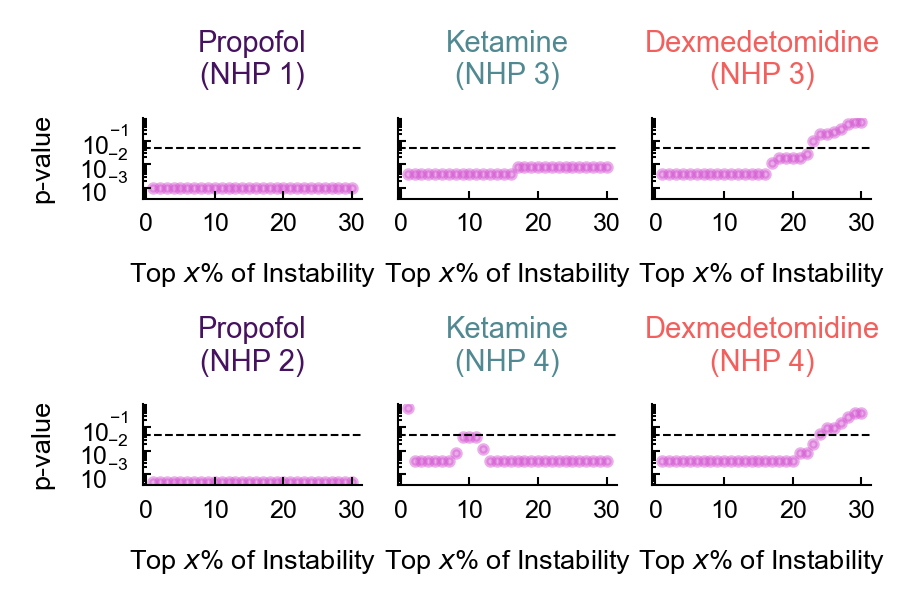

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(3, 2), sharey=True)

max_top_percent = max(top_percents)
plot_top_percents = np.array(top_percents)[np.array(top_percents) <= max_top_percent]

for i, (data_class, agent) in enumerate(anesthetic_agent_list):
    for j, monkey in enumerate(all_section_means[(data_class, agent)]):
        ax = axs[j, i]
        wp_vals_anesthesia_awake = [wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['anesthesia_awake'] for top_percent in plot_top_percents]
        # wp_vals_emergence_awake = [wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['emergence_awake'] for top_percent in plot_top_percents]
        ax.scatter(plot_top_percents, wp_vals_anesthesia_awake, color=cfg.plotting.epoch_colors['anesthesia'], alpha=0.5)
        # ax.scatter(plot_top_percents, wp_vals_emergence_awake, color=cfg.plotting.epoch_colors['emergence'], alpha=0.5)
        ax.axhline(y=0.05, color='black', linestyle='--')
        ax.set_yscale('log')
        NHP_num = j+1 if agent == 'propofol' else j+3
        ax.set_title(f"{agent.capitalize()}\n(NHP {NHP_num})", color=cfg.plotting.curve_colors[agent], fontsize=7)
        ax.set_xlabel(f'Top $x$% of Instability')
        ax.set_xticks([0, 0.1, 0.2, 0.3], [0, 10, 20, 30])
        if i == 0:
            ax.set_ylabel(f'p-value')
anes_pts = plt.scatter([], [], label='Anesthesia-Awake', color=cfg.plotting.epoch_colors['anesthesia'])
# emerg_pts = plt.scatter([], [], label='Emergence-Awake', color=cfg.plotting.epoch_colors['emergence'])

# put legend under figure centered
# fig.legend(ncol=2, bbox_to_anchor=(0.52, -0.02), loc='center')
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, 'supp', 'stability-wilcoxon-across-top-percent.pdf'), transparent=True, bbox_inches='tight')
plt.show()


# Distribution of stability parameters

In [ ]:
top_percent = 0.1
for data_class, agent in anesthetic_agent_list:
    if agent == 'propofol':
        plot_range = (-15, 85)
    elif agent == 'ketamine':
        plot_range = (-30, 220)
    else:
        plot_range = (-30, 180)
    cfg.params.data_class = data_class
    common_times = np.arange(plot_range[0], plot_range[1], 1/4)
    all_interpolated_stability_params = {
        monkey: np.zeros((len(common_times), 0)) for monkey in agent_data[(data_class, agent)]['session_lists']
    }
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        
        for session in agent_data[(data_class, agent)]['session_lists'][monkey]['high']:
            df = agent_data[(data_class, agent)]['delase_results'][session]['all']
            if 'propofol' in agent:
                is_lever = False
            else:
                is_lever = True
            if is_lever:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"))
                infusion_time = session_file['sessionInfo']['infusionStart'][0, 0]
            else:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class, f"{session}.mat"))
                infusion_time = session_file['sessionInfo']['drugStart'][0]


            time_vals = (df.window_start.values - infusion_time) / 60
            num_eigs = df.stability_params.apply(lambda x: len(x[:int(top_percent*len(x))])).min()
            stability_params = np.vstack(df.stability_params.apply(lambda x: x[:num_eigs]).to_numpy())
            interpolated_stability_params = np.zeros((len(common_times), stability_params.shape[-1]))
            for i in range (stability_params.shape[-1]):
                interpolated_stability_params[:, i] = np.interp(common_times, time_vals, stability_params[:, i])
            all_interpolated_stability_params[monkey] = np.concatenate((all_interpolated_stability_params[monkey], interpolated_stability_params), axis=1)
    
    fig, axs = plt.subplots(2, 1, figsize=(3, 2))

    for i, monkey in enumerate(all_interpolated_stability_params):
        ax = axs[i]
        # 1. Find the global min and max of the stability parameters to define bin edges.
        min_val = np.min(all_interpolated_stability_params[monkey])
        max_val = np.max(all_interpolated_stability_params[monkey])

        # 2. Construct 20 histogram bins between the min and max values.
        num_bins = 20
        bins = np.linspace(min_val, max_val, num_bins + 1)

        # 3. Initialize an array to hold the histogram data for each time point.
        # The shape will be (number of time points, number of bins).
        histogram_data = np.zeros((len(common_times), num_bins))

        # 4. For each time point, compute the histogram of stability parameters.
        for t in range(len(common_times)):
            # Get all stability parameters at the current time point.
            params_at_t = all_interpolated_stability_params[monkey][t, :]
            # Compute the histogram. 'density=True' normalizes it to form a probability density.
            hist, _ = np.histogram(params_at_t, bins=bins, density=True)
            histogram_data[t, :] = hist

        # Use imshow to create the heatmap.
        # - Transpose histogram_data (.T) so time is on the x-axis.
        # - aspect='auto' allows the heatmap to fill the plot area.
        # - origin='lower' places the (0,0) index at the bottom-left.
        # - extent sets the coordinates of the heatmap image.
        # - cmap='hot' matches the color scheme of your example image.
        im = ax.imshow(
            histogram_data.T,
            aspect='auto',
            origin='lower',
            extent=[common_times[0], common_times[-1], min_val, max_val],
            cmap='hot'
        )

        # 6. Add a colorbar and axis labels.
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Density', rotation=270, labelpad=20, fontsize=6)
        ax.set_xlabel('Time (min)', fontsize=8)
        if is_lever:
            ax.set_ylabel(f'NHP {i+3}', fontsize=6)
        else:
            ax.set_ylabel(f'NHP {i+1}', fontsize=6)

        # 7. Set the y-axis ticks and limits to match your example plot.
        # The values are taken directly from the image you provided.
        # y_ticks_values = [-70.2, -53.8, -37.5, -21.2, -4.9, 11.4]
        # ax.set_yticks(y_ticks_values)
        # ax.set_ylim(bottom=y_ticks_values[0], top=y_ticks_values[-1])
        ax.tick_params(axis='both', which='major', labelsize=6)

        # 8. (Optional) Add vertical lines for specific events if you have the times.
        # The colors are chosen to approximate those in your image.
        # Replace the placeholder values (e.g., 2, 8, 60, 75) with your actual event times.
        ax.axvline(x=0, color='white', linestyle='--', linewidth=2)  # Pinkish
        ax.axvline(x=np.mean(agent_data[(data_class, agent)]['locs'][monkey]['high'])/60, color=cfg.plotting.curve_colors[agent], linestyle='--', linewidth=2)
        ax.axvline(x=np.mean(agent_data[(data_class, agent)]['rocs'][monkey]['high'])/60, color=cfg.plotting.curve_colors[agent], linestyle='--', linewidth=2)
    # add text to the left indicating the y axis is "Instability s^{-1}"
    ax.text(-0.3, 0.65, r'Instability s$^{-1}$', rotation=90, fontsize=8, transform=ax.transAxes)
    plt.suptitle(f"{agent.capitalize()}", color=cfg.plotting.curve_colors[agent])
    plt.savefig(os.path.join(img_save_dir, f"{agent}_stability_heatmap.pdf"), transparent=True, bbox_inches='tight')
    plt.show()

# Hyperparameter combos

In [16]:
for (data_class, agent) in anesthetic_agent_list:
    cfg.params.data_class = data_class
    session_list = agent_data[(data_class, agent)]['session_list']
    session_list = [session_list[-1]]
    session = session_list[0]
    section_info, _, _, _ = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    areas = ['all']
    pca_chosen = None
    verbose = False
    grid_search_results = get_grid_search_results(cfg, session_list, areas, len(section_info), pca_chosen, verbose=verbose)
    print(f"Number of models fit for {agent}: {(~np.isnan(grid_search_results[session]['all']['mats']['aic']))[0].sum()} ({grid_search_results[session]['all']['mats']['aic'].shape[0]} windows)")


Number of models fit for propofol: 814 (20 windows)
Number of models fit for ketamine: 630 (32 windows)
Number of models fit for dexmedetomidine: 654 (32 windows)


In [22]:
# Create hyperparameter table for Word
import pandas as pd
from datetime import datetime

# Animal mapping
animal_to_nhp = {
    'Mary': 'NHP 1',
    'MrJones': 'NHP 2',
    'SPOCK': 'NHP 3',
    'PEDRI': 'NHP 4'
}

def parse_session_id(session_id):
    """Parse session ID to extract animal name and date"""
    # Handle two formats:
    # 1. Propofol: ANIMAL-Anesthesia-YYYYMMDD-NN (e.g., MrJones-Anesthesia-20160125-01)
    # 2. Ketamine/Dexmedetomidine: ANIMAL_AGENT_YYYYMMDD (e.g., PEDRI_Dexmedetomidine_20220324)
    
    if '-' in session_id:
        # Propofol format: ANIMAL-Anesthesia-YYYYMMDD-NN
        parts = session_id.split('-')
        animal = parts[0]
        # Date is in parts[2] (YYYYMMDD)
        if len(parts) >= 3:
            date_str = parts[2]
            try:
                date = datetime.strptime(date_str, '%Y%m%d')
                return animal, date
            except:
                return animal, None
        return animal, None
    else:
        # Ketamine/Dexmedetomidine format: ANIMAL_AGENT_YYYYMMDD
        parts = session_id.split('_')
        animal = parts[0]
        date_str = parts[-1]  # YYYYMMDD
        try:
            date = datetime.strptime(date_str, '%Y%m%d')
            return animal, date
        except:
            return animal, None

# Collect all hyperparameter data
table_data = []
for (data_class, agent) in anesthetic_agent_list:
    if 'grid_params_to_use' not in agent_data[(data_class, agent)]:
        continue
    
    grid_params = agent_data[(data_class, agent)]['grid_params_to_use']
    
    # Group sessions by animal
    animal_sessions = {}
    for session_id in grid_params.keys():
        animal, date = parse_session_id(session_id)
        if animal not in animal_sessions:
            animal_sessions[animal] = []
        animal_sessions[animal].append((session_id, date))
    
    # Process each animal
    for animal, sessions in animal_sessions.items():
        # Sort sessions chronologically
        sessions.sort(key=lambda x: x[1] if x[1] else datetime.max)
        
        # Get NHP number
        nhp_label = animal_to_nhp.get(animal, animal)
        
        # Add each session as a row
        for session_num, (session_id, date) in enumerate(sessions, 1):
            if 'all' in grid_params[session_id]:
                params = grid_params[session_id]['all']
                row = {
                    'Agent': agent.capitalize(),
                    'Animal': nhp_label,
                    'Session #': session_num,
                    'n_delays': params.get('n_delays', 'N/A'),
                    'rank': params.get('rank', 'N/A')
                }
                table_data.append(row)

# Create DataFrame
df_hyperparams = pd.DataFrame(table_data)

# Sort by Agent, then Animal, then Session #
# Define custom order for Agent
agent_order = ['Propofol', 'Ketamine', 'Dexmedetomidine']
df_hyperparams['Agent'] = pd.Categorical(df_hyperparams['Agent'], categories=agent_order, ordered=True)

# Define custom order for Animal (NHP 1, NHP 2, NHP 3, NHP 4)
animal_order = ['NHP 1', 'NHP 2', 'NHP 3', 'NHP 4']
df_hyperparams['Animal'] = pd.Categorical(df_hyperparams['Animal'], categories=animal_order, ordered=True)

# Sort the DataFrame
df_hyperparams = df_hyperparams.sort_values(['Agent', 'Animal', 'Session #']).reset_index(drop=True)

# Display the table
print("="*100)
print("HYPERPARAMETERS TABLE")
print("="*100)
print("\n")
print(df_hyperparams.to_string(index=False))
print("\n")

# Save as CSV (easy to import into Word)
csv_path = os.path.join(img_save_dir, 'hyperparameters_table.csv')
df_hyperparams.to_csv(csv_path, index=False)
print(f"Table saved to: {csv_path}")
print("\n")

# Create HTML table (Word can import HTML tables nicely)
html_path = os.path.join(img_save_dir, 'hyperparameters_table.html')
html_table = df_hyperparams.to_html(index=False, classes='table', table_id='hyperparameters')
with open(html_path, 'w') as f:
    f.write(html_table)
print(f"HTML table saved to: {html_path}")
print("You can open this HTML file in Word by: File > Open > Select HTML file")
print("\n")

# Also create a tab-separated version (easy to paste into Word)
tsv_path = os.path.join(img_save_dir, 'hyperparameters_table.tsv')
df_hyperparams.to_csv(tsv_path, sep='\t', index=False)
print(f"Tab-separated table saved to: {tsv_path}")
print("You can copy-paste this directly into Word")
print("\n")

# Display formatted table
print("Formatted version:")
print("="*100)
print(df_hyperparams.to_string(index=False))


HYPERPARAMETERS TABLE


          Agent Animal  Session #  n_delays  rank
       Propofol  NHP 1          1         5  1150
       Propofol  NHP 1          2         5  1100
       Propofol  NHP 1          3         5  1150
       Propofol  NHP 1          4         5  1150
       Propofol  NHP 1          5         5  1100
       Propofol  NHP 1          6         5  1100
       Propofol  NHP 1          7         5  1100
       Propofol  NHP 1          8         5  1100
       Propofol  NHP 1          9         5  1100
       Propofol  NHP 1         10         5  1100
       Propofol  NHP 2          1         5  1000
       Propofol  NHP 2          2         5  1000
       Propofol  NHP 2          3         5  1000
       Propofol  NHP 2          4         5  1050
       Propofol  NHP 2          5         5  1050
       Propofol  NHP 2          6         5  1050
       Propofol  NHP 2          7         5  1000
       Propofol  NHP 2          8         5  1050
       Propofol  NHP 2    